# cifar10-cnn-regularization

Use the "Run" button to execute the code.

In [4]:
!pip install jovian --upgrade --quiet

In [5]:
import jovian

In [6]:
# Execute this to save new versions of the notebook
jovian.commit(project="cifar10-cnn-regularization")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········


[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/noumanamir453/cifar10-cnn-regularization


'https://jovian.ai/noumanamir453/cifar10-cnn-regularization'

# Importing Modules

In [7]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [8]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)



['train', 'test']
['deer', 'horse', 'ship', 'automobile', 'dog', 'cat', 'bird', 'truck', 'airplane', 'frog']


In [9]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [10]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [11]:
batch_size = 400

In [12]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Using a GPU

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
# Device DataLoaders
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training the Model

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.10105769336223602, 'val_loss': 2.302708387374878}]

In [21]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00393, train_loss: 1.5032, val_loss: 1.2562, val_acc: 0.5952
Epoch [1], last_lr: 0.00935, train_loss: 1.1143, val_loss: 1.0948, val_acc: 0.6441
Epoch [2], last_lr: 0.00972, train_loss: 0.8228, val_loss: 0.7026, val_acc: 0.7591
Epoch [3], last_lr: 0.00812, train_loss: 0.6656, val_loss: 0.5737, val_acc: 0.8002
Epoch [4], last_lr: 0.00556, train_loss: 0.5004, val_loss: 0.6600, val_acc: 0.7739
Epoch [5], last_lr: 0.00283, train_loss: 0.4006, val_loss: 0.4047, val_acc: 0.8642
Epoch [6], last_lr: 0.00077, train_loss: 0.2924, val_loss: 0.3026, val_acc: 0.8963
Epoch [7], last_lr: 0.00000, train_loss: 0.2224, val_loss: 0.2791, val_acc: 0.9040
CPU times: user 38.8 s, sys: 19.9 s, total: 58.7 s
Wall time: 4min 15s


In [23]:
%%time
history += fit_one_cycle(epochs+8, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00138, train_loss: 0.2571, val_loss: 0.4046, val_acc: 0.8689
Epoch [1], last_lr: 0.00394, train_loss: 0.3731, val_loss: 0.6794, val_acc: 0.7955
Epoch [2], last_lr: 0.00703, train_loss: 0.5015, val_loss: 0.6895, val_acc: 0.7644
Epoch [3], last_lr: 0.00935, train_loss: 0.5257, val_loss: 0.9172, val_acc: 0.7084
Epoch [4], last_lr: 0.00999, train_loss: 0.5179, val_loss: 0.8631, val_acc: 0.7152
Epoch [5], last_lr: 0.00972, train_loss: 0.4927, val_loss: 0.6537, val_acc: 0.7861
Epoch [6], last_lr: 0.00908, train_loss: 0.4688, val_loss: 0.6208, val_acc: 0.7902
Epoch [7], last_lr: 0.00812, train_loss: 0.4385, val_loss: 0.5168, val_acc: 0.8254
Epoch [8], last_lr: 0.00691, train_loss: 0.4150, val_loss: 0.4778, val_acc: 0.8374
Epoch [9], last_lr: 0.00556, train_loss: 0.3823, val_loss: 0.4629, val_acc: 0.8435
Epoch [10], last_lr: 0.00416, train_loss: 0.3297, val_loss: 0.3578, val_acc: 0.8829
Epoch [11], last_lr: 0.00283, train_loss: 0.2750, val_loss: 0.3219, val_acc: 0.8924
Ep

In [24]:
%%time
history += fit_one_cycle(epochs+12, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00103, train_loss: 0.1180, val_loss: 0.2860, val_acc: 0.9124
Epoch [1], last_lr: 0.00279, train_loss: 0.1581, val_loss: 0.4269, val_acc: 0.8739
Epoch [2], last_lr: 0.00519, train_loss: 0.2639, val_loss: 0.4467, val_acc: 0.8460
Epoch [3], last_lr: 0.00759, train_loss: 0.3652, val_loss: 0.5288, val_acc: 0.8290
Epoch [4], last_lr: 0.00936, train_loss: 0.4044, val_loss: 0.5238, val_acc: 0.8225
Epoch [5], last_lr: 0.01000, train_loss: 0.4158, val_loss: 0.6157, val_acc: 0.7892
Epoch [6], last_lr: 0.00987, train_loss: 0.4173, val_loss: 0.5557, val_acc: 0.8086
Epoch [7], last_lr: 0.00950, train_loss: 0.3980, val_loss: 0.5068, val_acc: 0.8290
Epoch [8], last_lr: 0.00891, train_loss: 0.3905, val_loss: 0.5361, val_acc: 0.8263
Epoch [9], last_lr: 0.00812, train_loss: 0.3680, val_loss: 0.4762, val_acc: 0.8478
Epoch [10], last_lr: 0.00717, train_loss: 0.3504, val_loss: 0.4361, val_acc: 0.8591
Epoch [11], last_lr: 0.00611, train_loss: 0.3251, val_loss: 0.5450, val_acc: 0.8244
Ep

In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

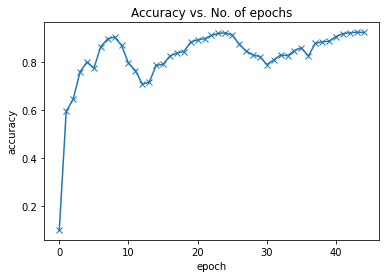

In [26]:
plot_accuracies(history)

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

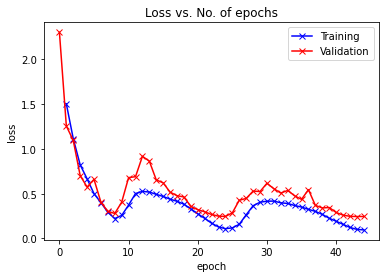

In [28]:
plot_losses(history)

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

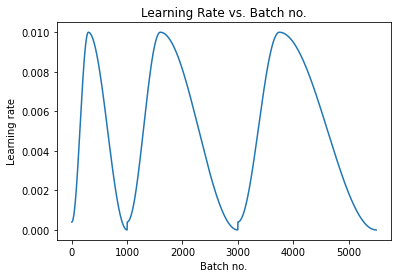

In [31]:
plot_lrs(history)

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


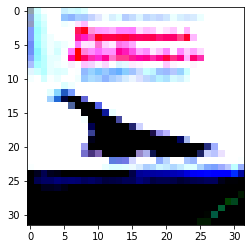

In [33]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: automobile , Predicted: automobile


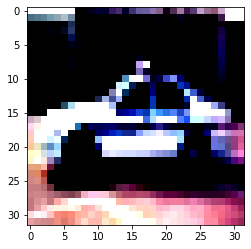

In [34]:
img, label = valid_ds[1006]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

In [35]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [36]:
!pip install jovian --upgrade --quiet

In [37]:
import jovian

In [38]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [ ]:
ovian.commit(project='c', environment=None, outputs=['cifar10-resnet9.pth'])